# Imports

In [1]:
# Freqtrade Workspace

# Notebook Helpers
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

# Standard Imports
from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta
from copy import deepcopy

import attr
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import pandas as pd
import numpy as np
import qgrid
pd.set_option('display.max_rows', 200)

# Resolve CWD
gc.collect()
nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)
        logging.getLogger("distributed.utils_perf").setLevel(logging.ERROR)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils
from freqtrade.nbtools.preset import LocalPreset, ConfigPreset, FilePreset, CloudPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools import plotting, configs
from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
PATH_DATA = PATH_MOUNT / "data"
PATH_PRESETS = PATH_MOUNT / "presets"
PATH_STRATEGIES = PATH_PRESETS / ".strategy_files"
DATALOADER = DataLoader(max_n_datasets=5)

# Define custom functions
def foo() -> str:
    return "bar"

env: WANDB_SILENT=true
freqtrade.nbtools.backtest - Initialized DataLoader with 5 max datas.


In [2]:
""" 
Strategy Backtesting Principles:

- In this case, we use "Long only" strategy.

- ZOOM OUT: Test in various market conditions, such as:
   > Bear Period - Profits should slight loss or ranging.
   > Bull Period - Profits must up!
   > Ranging Period - Profits should at least ranging. Up profits are welcome.

- ZOOM IN: Current condition validation: 
   > Test strategy to last 1 month data, determine if it's suitable to dry run.
"""
# List of available file strategies
strats = [it.name.replace(".py", "") for it in PATH_STRATEGIES.glob("*.py")]
paths = [str(it) for it in PATH_STRATEGIES.glob("*.py")]
df_strats = pd.DataFrame({"name": strats, "path": paths})
qgrid.show_grid(df_strats)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

# Strategy File Backtesting

Preset name: RalliV1
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Add strategy search path C:\CS\Python\crypto-collection\freqtrade\mount\presets\.strategy_files
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Add strategy search path C:\CS\Python\crypto-collection\freqtrade\mount\presets\.strategy_files
freqtrade.nbtools.preset.base_preset - Setting config for RalliV1 ...
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to C:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210101-
freqtrade.nbtools.helper - Strategy using minimal_roi: {'0': 0.04, '40': 0.032, '87': 0.018, '201': 0}
freqtrade.nbtools.helper - Strategy using timeframe: 5m
freqtrade.nbtools.helper - Strategy using stoploss: -0.3
freqtrade.nbtools.helper - Strategy using trailing_stop: False
freq

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  'NotAnotherSMAOffsetStrategy_uzi3__backtest-2021-09-01_12-25-59'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


C:\Users\User\.virtualenvs\freqtrade-futures\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\User\.virtualenvs\freqtrade-futures\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


freqtrade.nbtools.helper - "Backtest" executed in 24.54s
freqtrade.nbtools.backtest - Logging preset...
freqtrade.nbtools.backtest - [LOG PRESET OFFLINE SUCCESS]
freqtrade.nbtools.backtest - Sync preset with name: RalliV1__backtest-2021-09-01_12-26-53
freqtrade.nbtools.backtest - with random name: hardworking-superman-memory
freqtrade.nbtools.backtest - [WANDB LOG PRESET CONTINUES IN BACKGROUND]
freqtrade.nbtools.helper - "Whole Backtesting Process (Backtest + Log)" executed in 25.84s


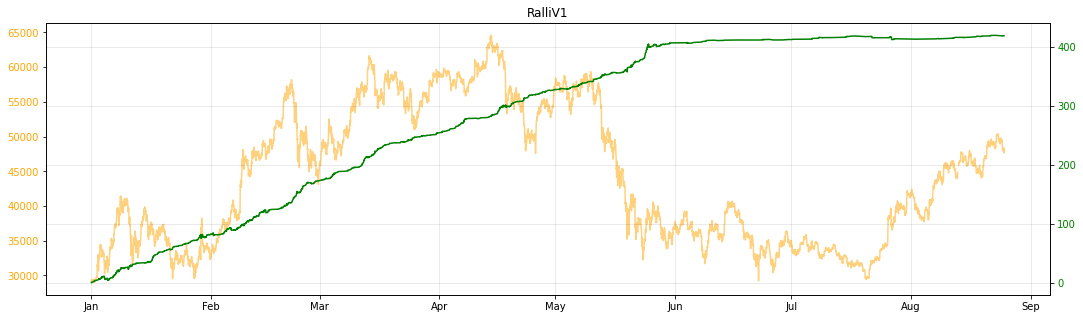

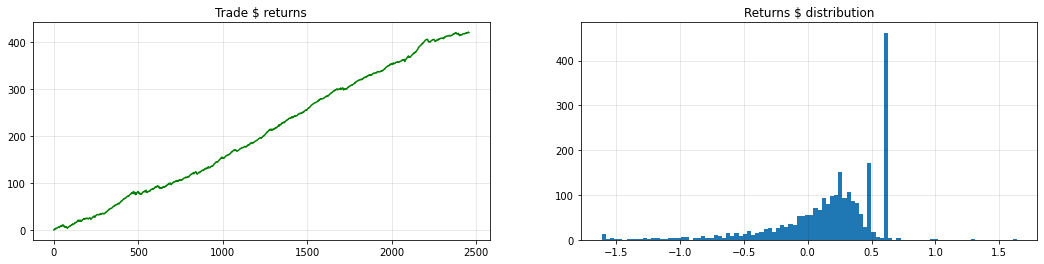

,Portfolio Summary
Trades,2458.00
Min Balance,0.48
Max Balance,420.19
Final Balance,419.57
Avg. Return (%),1.14
Avg. Return ($),0.17
Avg. Trade Duration (h),0.85


freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  'RalliV1__backtest-2021-09-01_12-26-53'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [7]:
# Backtest settings
strategy_classname = "RalliV1"  # Strategy Filename and Classname must same! 
timerange          = "20210101-"
pairs              = PAIRS_HIGHCAP_NONSTABLE

"Uncomment this if you want to test the Long Term strategy"
# timerange = "20160101-"
# pairs = [
#     "BTC/USDT", "ETH/USDT", "ADA/USDT", "XRP/USDT", "EOS/USDT", "XMR/USDT", "RVN/USDT", "ZEC/USDT", "NANO/USDT", "NEO/USDT",
#     "BCH/USDT", "LTC/USDT", "ETC/USDT", "XLM/USDT", "MKR/USDT", "DASH/USDT", "ICX/USDT", "BNB/USDT", "LINK/USDT", "XEM/USDT",
# ]


preset = FilePreset(
    timerange = timerange,
    config_dict = configs.DEFAULT,
    path_to_file = PATH_STRATEGIES / f"{strategy_classname}.py",
    path_data = PATH_DATA,
)

# Optional override
preset.overwrite_config(
    strategy_search_path = PATH_STRATEGIES,
    pairs                = pairs,
#     max_open_trades      = 2,
#     starting_balance     = 30,
#     stake_amount         = "unlimited",
#     timeframe            = "6h", # 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
)

stats, summary = backtest(preset, preset.default_strategy_code, clsname=strategy_classname, dataloader=DATALOADER)
trades = pd.DataFrame(stats["strategy"][strategy_classname]["trades"])
plotting.plot_profits_timerange(
    trades,
    timerange,
    path_mount = PATH_MOUNT,
    name = preset.name
)

# Plot Profits

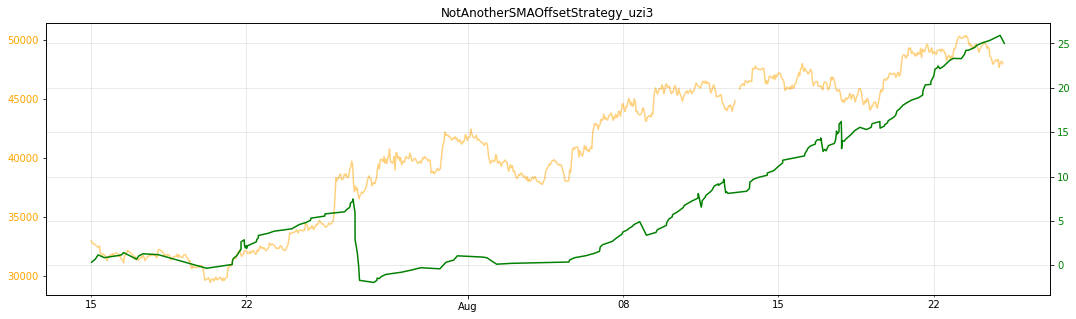

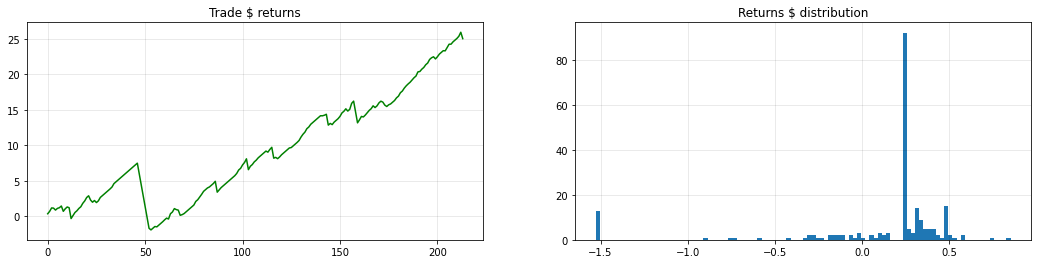

,Portfolio Summary
Trades,214.00
Min Balance,-1.93
Max Balance,25.92
Final Balance,25.01
Avg. Return (%),0.78
Avg. Return ($),0.12
Avg. Trade Duration (h),4.23


In [6]:
plotting.plot_profits(
    trades,
    start = "2021-07-15",
    end = "2021-09-01",
    path_mount = PATH_MOUNT,
    name = preset.name,
)

# Statistics

In [6]:
def process_result_dataframe(result_df):
    result_df = result_df.drop(columns=["profit_mean", "profit_total", "profit_sum"])
    result_df = result_df.sort_values(by=["profit_total_abs"], ascending=False)
    result_df = result_df.round(2)
    return result_df

# Running this cell will print backtest results
results = deepcopy(stats["strategy"][strategy_classname])

# Results per pair
results_per_pair = pd.DataFrame(results["results_per_pair"]).set_index("key")
results_per_pair = process_result_dataframe(results_per_pair)

# Sell reason stats
sells = pd.DataFrame(results['sell_reason_summary']).set_index("sell_reason")
sells = process_result_dataframe(sells)

# Left open trades
left_open_trades = pd.DataFrame(results['left_open_trades']).set_index("key")
left_open_trades = process_result_dataframe(left_open_trades)

# Summary metrics
metrics = text_table_add_metrics(results)
advanced_metrics = deepcopy(stats["metadata"])
advanced_metrics["profit_mean"] = advanced_metrics["profit_mean"] * 100
advanced_metrics["profit_median"] = advanced_metrics["profit_median"] * 100
advanced_metrics["profit_total"] = advanced_metrics["profit_total"] * 100

for key in list(advanced_metrics):
    value = advanced_metrics[key]
    valid = any(isinstance(value, it) for it in [str, int, float, bool])
    
    if not valid:
        del advanced_metrics[key]
        continue
    
    if isinstance(value, float):
        advanced_metrics[key] =  round(value, 3)
    
    advanced_metrics[key] = [advanced_metrics[key]]
    
advanced_metrics_df = pd.DataFrame(advanced_metrics)
    
print("Freqtrade Summary Metrics")
print("=" * 48 + "\n" + metrics + "\n" + "=" * 48)
print("Results Per Pair")
display(results_per_pair)
print("Sell Reasons")
display(sells)
print("Left Open Trades")
display(left_open_trades)
print("Advanced Metrics")
print("Preset Name:", advanced_metrics_df["preset_name"][0])
display(advanced_metrics_df.drop(columns=["preset_name"]).T)# Running this cell will print backtest results
results = stats["strategy"][strategy_classname]

Freqtrade Summary Metrics
| Metric                 | Value               |
|------------------------+---------------------|
| Backtesting from       | 2020-12-29 13:40:00 |
| Backtesting to         | 2021-08-25 04:35:00 |
| Max open trades        | 6                   |
|                        |                     |
| Total/Daily Avg Trades | 1992 / 8.37         |
| Starting balance       | 1000.000 USDT       |
| Final balance          | 1218.166 USDT       |
| Absolute profit        | 218.166 USDT        |
| Total profit %         | 21.82%              |
| Avg. stake amount      | 15.000 USDT         |
| Total trade volume     | 29880.000 USDT      |
|                        |                     |
| Best Pair              | DOGE/USDT 365.0%    |
| Worst Pair             | ANKR/USDT -39.97%   |
| Best trade             | DOGE/USDT 71.86%    |
| Worst trade            | DOGE/USDT -15.17%   |
| Best day               | 38.591 USDT         |
| Worst day              | -11.062 USDT    

,trades,profit_mean_pct,profit_sum_pct,profit_total_abs,profit_total_pct,duration_avg,wins,draws,losses
key,,,,,,,,,
TOTAL,1992,0.73,1452.99,218.17,21.82,0:49:00,1432,0,560
DOGE/USDT,164,2.23,365.00,54.80,5.48,0:38:00,128,0,36
HOT/USDT,115,1.22,139.82,20.99,2.10,0:47:00,86,0,29
XLM/USDT,30,3.58,107.27,16.11,1.61,0:46:00,25,0,5
MATIC/USDT,119,0.77,91.57,13.75,1.37,0:52:00,88,0,31
NANO/USDT,111,0.64,71.40,10.72,1.07,0:41:00,79,0,32
ETC/USDT,52,1.08,56.32,8.46,0.85,0:52:00,39,0,13
ONE/USDT,108,0.48,51.50,7.73,0.77,0:52:00,72,0,36
CHZ/USDT,79,0.59,46.84,7.03,0.70,0:45:00,60,0,19


Sell Reasons


,trades,wins,draws,losses,profit_mean_pct,profit_sum_pct,profit_total_abs,profit_total_pct
sell_reason,,,,,,,,
trailing_stop_loss,616,587,0,29,3.71,2287.45,343.46,381.24
sell signal (ema trima ),794,535,0,259,0.01,4.08,0.61,0.68
sell signal (ema ),112,66,0,46,-0.06,-7.02,-1.05,-1.17
sell signal (trima ),418,244,0,174,-0.10,-42.69,-6.41,-7.11
stop_loss,52,0,0,52,-15.17,-788.83,-118.44,-131.47


Left Open Trades


,trades,profit_mean_pct,profit_sum_pct,profit_total_abs,profit_total_pct,duration_avg,wins,draws,losses
key,,,,,,,,,
TOTAL,0,0.0,0.0,0.0,0.0,0:00,0,0,0


Advanced Metrics
Preset Name: MultiMA_TSL__backtest-2021-08-28_13-20-49


,0
random_name,boring-thanos-remote
preset_type,FilePreset
backtest_date,2021-08-28 13:20:49
leverage,1
direction,long
is_hedging,False
fee,0.001
num_pairs,61
data_source,binance
win_rate,0.719


In [7]:
trades.columns

Index(['pair', 'stake_amount', 'amount', 'open_date', 'close_date',
       'open_rate', 'close_rate', 'fee_open', 'fee_close', 'trade_duration',
       'profit_ratio', 'profit_abs', 'sell_reason', 'initial_stop_loss_abs',
       'initial_stop_loss_ratio', 'stop_loss_abs', 'stop_loss_ratio',
       'min_rate', 'max_rate', 'is_open', 'open_timestamp', 'close_timestamp'],
      dtype='object')

In [78]:
DATALOADER.clear()
gc.collect()

0